In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def add_sensor_constraints(file, x_coord, y_coord, sensor_id, bank_sensor_id, sensor_length):
    file.write("# Sensor "+str(sensor_id)+"\n")
    file.write("create_pblock sensor_"+str(sensor_id)+"\n")
    file.write("resize_pblock sensor_"+str(sensor_id)+" -add {SLICE_X"+str(x_coord)+"Y"+str(y_coord)+":SLICE_X"+str(x_coord)+"Y"+str(y_coord+sensor_length)+"}\n")
    file.write("add_cells_to_pblock sensor_"+str(sensor_id)+" [get_cells [list level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen["+str(bank_sensor_id)+"].sensor/tdc0]] -clear_locs\n")
    file.write("set_property LOC SLICE_X"+str(x_coord)+"Y"+str(y_coord)+" [get_cells [list level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen["+str(bank_sensor_id)+"].sensor/tdc0/first_fine_carry]]\n")
    file.write("set_property DONT_TOUCH true [get_cells [list level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen["+str(bank_sensor_id)+"].sensor/tdc0/*]]\n")
    file.write("set_property EXCLUDE_PLACEMENT 1 [get_pblocks sensor_"+str(sensor_id)+"]\n\n")

In [3]:
def generate_pblock(file, name, resources, cells, exclude_placement):
    file.write("\n# "+name+" PBLOCK\n")
    file.write("create_pblock "+name+"\n")
    file.write("resize_pblock "+name+" -add {")
    for resource in resources:
        for area in range(len(resources[resource])):
            file.write(resource+"_X"+str(resources[resource][area]["X_L"])+"Y"+str(resources[resource][area]["Y_B"])+":"+resource+"_X"+str(resources[resource][area]["X_R"])+"Y"+str(resources[resource][area]["Y_T"])+" ")
    file.write("}\n")
    if(cells!=[]):
        for cell in cells:
            print(cell)
            file.write("add_cells_to_pblock "+name+" [get_cells [list "+cell+"]] -clear_locs\n")
    if(exclude_placement==1):
        file.write("set_property EXCLUDE_PLACEMENT 1 [get_pblocks "+name+"]\n")

In [4]:
def is_valid_placement(slices, x_coord, y_coord, sensor_length):
    for y in range(0, sensor_length):
        if(not (slices[slices['location'] == 'X'+str(x_coord)+'Y'+str(y_coord+y)].any()[0])):
           return False
        
    return True

In [5]:
TOP_SLR         = {"SLICE":   [{"X_L": 0, "Y_B": 600, "X_R": 168, "Y_T": 899}],
                   "DSP48E2": [{"X_L": 0, "Y_B": 240, "X_R": 18, "Y_T": 359}],
                   "RAMB18":  [{"X_L": 0, "Y_B": 240, "X_R": 11, "Y_T": 359}],
                   "RAMB36":  [{"X_L": 0, "Y_B": 120, "X_R": 11, "Y_T": 179}],
                   "URAM288": [{"X_L": 0, "Y_B": 160, "X_R": 3, "Y_T": 239}]}
VICTIM_PBLOCK   = {"SLICE":   [{"X_L": 0, "Y_B": 660, "X_R": 82, "Y_T": 899}],
                   "DSP48E2": [{"X_L": 0, "Y_B": 264, "X_R": 9, "Y_T": 359}],
                   "RAMB18":  [{"X_L": 0, "Y_B": 264, "X_R": 5, "Y_T": 359}],
                   "RAMB36":  [{"X_L": 0, "Y_B": 132, "X_R": 5, "Y_T": 179}],
                   "URAM288": [{"X_L": 0, "Y_B": 176, "X_R": 1, "Y_T": 239}]}
CPU_PBLOCK      = {"SLICE":   [{"X_L": 60, "Y_B": 780, "X_R": 82, "Y_T": 839}],
                   "DSP48E2": [{"X_L": 9, "Y_B": 312, "X_R": 9, "Y_T": 335}],
                   "RAMB18":  [{"X_L": 5, "Y_B": 312, "X_R": 5, "Y_T": 335}],
                   "RAMB36":  [{"X_L": 5, "Y_B": 156, "X_R": 5, "Y_T": 167}],
                   "URAM288": [{"X_L": 1, "Y_B": 208, "X_R": 1, "Y_T": 223}]}
BUFFER_PBLOCK = {"SLICE":   [{"X_L": 83, "Y_B": 660, "X_R": 84, "Y_T": 899}]}
#ATTACKER_PBLOCK = {"SLICE":   [{"X_L": 84, "Y_B": 660, "X_R": 168, "Y_T": 899}]}
ATTACKER_PBLOCK = {"SLICE":   [{"X_L": 85, "Y_B": 660, "X_R": 168, "Y_T": 899}],
                   "DSP48E2": [{"X_L": 10, "Y_B": 264, "X_R": 18, "Y_T": 359}],
                   "RAMB18":  [{"X_L": 6, "Y_B": 264, "X_R": 11, "Y_T": 359}],
                   "RAMB36":  [{"X_L": 6, "Y_B": 132, "X_R": 11, "Y_T": 179}],
                   "URAM288": [{"X_L": 2, "Y_B": 176, "X_R": 3, "Y_T": 239}]}
#SENSOR_PBLOCK   = {"SLICE":   {"X_L": 84, "Y_B": 660, "X_R": 168, "Y_T": 899}}#{"X_L": 0, "Y_B": 0, "X_R": 150, "Y_T": 100}
SENSOR_PBLOCK   = {"SLICE":   {"X_L": 86, "Y_B": 660, "X_R": 168, "Y_T": 899}}#{"X_L": 0, "Y_B": 0, "X_R": 150, "Y_T": 100}
CTRL_PBLOCK     = {"SLICE":   [{"X_L": 0, "Y_B": 600, "X_R": 168, "Y_T": 659}],
                   "DSP48E2": [{"X_L": 0, "Y_B": 240, "X_R": 18, "Y_T": 263}],
                   "RAMB18":  [{"X_L": 0, "Y_B": 240, "X_R": 11, "Y_T": 263}],
                   "RAMB36":  [{"X_L": 0, "Y_B": 120, "X_R": 11, "Y_T": 131}],
                   "URAM288": [{"X_L": 0, "Y_B": 160, "X_R": 3, "Y_T": 175}]}

In [6]:
N_SENSORS_PER_BANK = 30
N_BANKS = 1
N_SENSOR_ROWS = 6
SENSOR_SIZE =  20
SENSOR_GROUP_SIZE = 5
SENSOR_SPACING = 2

In [7]:
slices = pd.read_csv("slices.txt", header=None)
slices[['bla', 'location']] = slices[0].str.split('_', expand=True)
slices = slices.drop([0, "bla"], axis=1)
slices[['X', 'Y']] = slices["location"].str.split('Y', expand=True)
slices['X'] = slices['X'].str.extract('(\d+)').astype(int)
slices['Y'] = slices['Y'].astype(int)

In [8]:
if (N_SENSOR_ROWS*SENSOR_SIZE+(N_SENSOR_ROWS-1)*SENSOR_SPACING) > (SENSOR_PBLOCK["SLICE"]["Y_T"]-SENSOR_PBLOCK["SLICE"]["Y_B"]):
    print("The specified number of sensor rows with the specified spacing does not fit in the pblock")

N_SENSORS = N_SENSORS_PER_BANK*N_BANKS

if N_SENSORS_PER_BANK % SENSOR_GROUP_SIZE != 0:
    print("The number of sensors in a bank must be divisible by the number of sensors in a cluster!")
else:
    N_GROUPS_PER_BANK = int(N_SENSORS_PER_BANK/SENSOR_GROUP_SIZE)
    
N_GROUPS = N_GROUPS_PER_BANK*N_BANKS
    
if N_GROUPS % N_SENSOR_ROWS != 0:
    print("Number of desired sensor groups is not divisible by the number of desired sensor rows!")
    print(N_GROUPS, "vs", N_SENSOR_ROWS)
else:
    N_GROUPS_PER_ROW = N_GROUPS//N_SENSOR_ROWS

if(N_GROUPS_PER_ROW > 1):
    horizontal_stride = SENSOR_GROUP_SIZE+((SENSOR_PBLOCK["SLICE"]["X_R"]-SENSOR_PBLOCK["SLICE"]["X_L"])-N_GROUPS_PER_ROW*SENSOR_GROUP_SIZE)//(N_GROUPS_PER_ROW-1)
else:
    horizontal_stride = 0
vertical_stride = SENSOR_SIZE+((SENSOR_PBLOCK["SLICE"]["Y_T"]-SENSOR_PBLOCK["SLICE"]["Y_B"])-SENSOR_SIZE*N_SENSOR_ROWS)//(N_SENSOR_ROWS-1)

print("N_GROUPS_PER_BANK: ", N_GROUPS_PER_BANK)
print("N_GROUPS ", N_GROUPS)
print("N_GROUPS_PER_ROW: ", N_GROUPS_PER_ROW)
print("horizontal_stride: ", horizontal_stride)
print("vertical_stride: ", vertical_stride)

N_GROUPS_PER_BANK:  6
N_GROUPS  6
N_GROUPS_PER_ROW:  1
horizontal_stride:  0
vertical_stride:  43


In [9]:
bank_id = 0
sensor_id = 0
bank_sensor_id = 0

placement = pd.DataFrame(np.zeros((slices['Y'].max(),slices['X'].max())))

constraints = open("../pblocks_TDC.tcl", "w")

#generate_pblock(constraints, "TOP_SLR", TOP_SLR, [], 0)
generate_pblock(constraints, "VICTIM", VICTIM_PBLOCK, [], 0)
generate_pblock(constraints, "SEPARATION", BUFFER_PBLOCK, [], 1)
generate_pblock(constraints, "CPU", CPU_PBLOCK, ["level0_i/ulp/PicoRV32_SCA_kernel_1/U0/CPU"], 1)
generate_pblock(constraints, "ATTACKER", ATTACKER_PBLOCK, ["level0_i/ulp/PicoRV32_SCA_kernel_1/U0/trace_fifo",
                                                           "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/FifoDumper",
                                                           "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen[*].IDC_reg[*][*]",
                                                           "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen[*].IDF_reg[*][*]"], 0)
generate_pblock(constraints, "CTRL", CTRL_PBLOCK, ["level0_i/ulp/PicoRV32_SCA_kernel_1/U0/AxiFIFOFlusher",
                                                   "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/AxiLiteFSM",
                                                   "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/AxiLoader",
                                                   #"level0_i/ulp/PicoRV32_SCA_kernel_1/U0/bank_generate[*]*/sensors/sensor_gen[*].IDC_reg[*][*]",
                                                   #"level0_i/ulp/PicoRV32_SCA_kernel_1/U0/bank_generate[*]*/sensors/sensor_gen[*].IDF_reg[*][*]",
                                                   "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/dump_sync",
                                                   "level0_i/ulp/PicoRV32_SCA_kernel_1/U0/trap_sync"], 0)

for i in range(0, N_GROUPS_PER_ROW):
    for j in range(0, N_SENSOR_ROWS):
        x_coord = SENSOR_PBLOCK["SLICE"]["X_L"]+i*horizontal_stride
        y_coord = SENSOR_PBLOCK["SLICE"]["Y_B"]+j*vertical_stride
        print("Sensor group :", i*N_SENSOR_ROWS+j)
        for k in range(0, SENSOR_GROUP_SIZE):
            
            while(is_valid_placement(slices, x_coord+k, y_coord, SENSOR_SIZE) == False):
                print("Sensor with anchor at location : X", x_coord+k, "Y", y_coord, "cannot be placed! Moving sensor to the right")
                x_coord += 1
                
            print("Sensor ", k, " : X", x_coord+k, "Y", y_coord)

            add_sensor_constraints(constraints, x_coord+k, y_coord, sensor_id, bank_sensor_id+1, SENSOR_SIZE)
            for yyy in range(y_coord, y_coord+SENSOR_SIZE):
                placement.iloc[yyy, x_coord+k] = 100
            sensor_id +=1
            bank_sensor_id = sensor_id % N_SENSORS_PER_BANK
            if(sensor_id>0 and sensor_id % N_SENSORS_PER_BANK==0):
                bank_id += 1
                
constraints.close()

level0_i/ulp/PicoRV32_SCA_kernel_1/U0/CPU
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/trace_fifo
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/FifoDumper
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen[*].IDC_reg[*][*]
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/sensors/sensor_gen[*].IDF_reg[*][*]
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/AxiFIFOFlusher
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/AxiLiteFSM
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/AxiLoader
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/dump_sync
level0_i/ulp/PicoRV32_SCA_kernel_1/U0/trap_sync
Sensor group : 0
Sensor  0  : X 86 Y 660
Sensor  1  : X 87 Y 660
Sensor  2  : X 88 Y 660
Sensor  3  : X 89 Y 660
Sensor  4  : X 90 Y 660
Sensor group : 1
Sensor  0  : X 86 Y 703
Sensor  1  : X 87 Y 703
Sensor  2  : X 88 Y 703
Sensor  3  : X 89 Y 703
Sensor  4  : X 90 Y 703
Sensor group : 2
Sensor  0  : X 86 Y 746
Sensor  1  : X 87 Y 746
Sensor  2  : X 88 Y 746
Sensor  3  : X 89 Y 746
Sensor  4  : X 90 Y 746
Sensor group : 3
Sensor  0  : X 86 Y 789
Sensor  1  : X

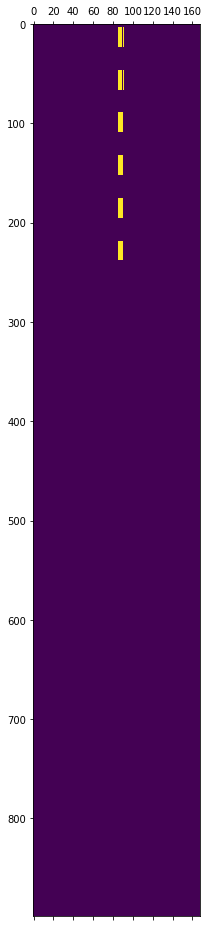

In [10]:
plt.matshow(placement.loc[::-1])
plt.show()

In [11]:
stop

NameError: name 'stop' is not defined